In [ ]:
import pandas as pd
import numpy as np
data = pd.read_csv("data.csv")
data = data.dropna()
data = data.drop(columns = ['Unnamed: 0','datetime'] )
all_data = data.values
print(all_data.shape)

(3035, 18)


In [ ]:
def maxminnorm(array):
    maxcols=array.max(axis=0)
    print(maxcols)
    mincols=array.min(axis=0)
    data_shape = array.shape
    data_rows = data_shape[0]
    data_cols = data_shape[1]
    t=np.empty((data_rows,data_cols))
    for i in range(data_cols):
        t[:,i]=(array[:,i]-mincols[i])/(maxcols[i]-mincols[i])
    return t

In [ ]:
all_data = maxminnorm(all_data)

[ 1.25606000e+02  1.25858000e+02  1.24542000e+02  1.25599000e+02
  3.74674000e+05  2.43697248e+00  2.31348241e+00  7.87677106e-01
  3.65602006e+02  1.90497271e+00  1.26696569e+02  1.24716200e+02
  1.24195726e+02  1.23993165e+02  1.24038767e+02  8.87300000e+00
  8.66766306e+00 -8.03427959e-02]


In [ ]:
def input_emb(original_data,seq):
    emb_list = []
    for i in range(0,len(original_data)-seq):
        temp = []
        for j in range(i,i+seq):
            temp.append(original_data[j])
        emb_list.append(temp)
    return emb_list

def label_emb(original_label,seq):
    emb_list = []
    for i in range(seq,len(original_label)):
        emb_list.append(original_label[i])
    return emb_list

In [ ]:
def sp(data,co):
  a = int(len(data)*co)
  train = data[0:a]
  test = data[a+1:]
  return train,test

In [ ]:
X_train,X_test = sp(all_data.tolist(),0.7)

In [ ]:
y_data = data['close'].values
date_time_list = data['datetime'].values
open_list = data['open'].values
high_list = data['high'].values
low_list = data['low'].values

In [ ]:
y_data.shape

(3035,)

In [ ]:
y_train,y_test = sp(y_data.tolist(),0.7)

_,data_time = sp(date_time_list.tolist(),0.7)
_,open_data = sp(open_list.tolist(),0.7)
_,high_data = sp(high_list.tolist(),0.7)
_,low_data = sp(low_list.tolist(),0.7)

In [ ]:
test=pd.DataFrame(data=X_test)
test['datetime'] = None
test['open'] = None
test['low'] = None
test['high'] = None
test['close'] = None
test.loc[:,'datetime'] = data_time
test.loc[:,'open'] = open_data
test.loc[:,'high'] = high_data
test.loc[:,'low'] = low_data
test.loc[:,'close'] = y_test
print(test)
test.to_csv('/content/for_backtesting_USD_JPY.csv')

            0         1         2  ...        16        17    close
0    0.710579  0.714851  0.717046  ...  0.248931  0.061986  110.930
1    0.706255  0.712993  0.717005  ...  0.280532  0.142591  111.321
2    0.706094  0.704387  0.706593  ...  0.239061  0.103051  110.669
3    0.700609  0.707342  0.707976  ...  0.271843  0.190506  111.140
4    0.711060  0.709659  0.718794  ...  0.338303  0.173423  111.048
..        ...       ...       ...  ...       ...       ...      ...
905  0.602987  0.603447  0.616627  ...  0.466108  0.447430  105.974
906  0.607071  0.615008  0.620348  ...  0.459326  0.660860  106.389
907  0.615120  0.614569  0.622056  ...  0.413122  0.455659  105.990
908  0.607832  0.617484  0.614878  ...  0.443947  0.748803  106.560
909  0.618764  0.622397  0.606723  ...  0.394282  0.135772  105.368

[910 rows x 19 columns]


In [ ]:
np.array(y_train).shape

(2124,)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
import torch.optim as optim
sequence = 7
input_emb_list_train = input_emb(X_train,sequence)
input_emb_list_val = input_emb(X_test,sequence)
label_emb_list_train = label_emb(y_train,sequence)
label_emb_list_val = label_emb(y_test,sequence)
input_batch_torch = torch.from_numpy(np.array(input_emb_list_train)).float()
target_batch_torch = torch.from_numpy(np.array(label_emb_list_train)).view(-1).float()
val_input = torch.from_numpy(np.array(input_emb_list_val)).float()

val_target =torch.from_numpy(np.array(label_emb_list_val)).view(-1).float()
print(target_batch_torch.numpy().shape)
type(input_batch_torch)

(2117,)


torch.Tensor

In [ ]:
n_input = 18
n_hidden = 50
n_class = 1
total_epoch = 2500
learning_rate = 0.01

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
import torch.optim as optim
class MAPE(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x, y):
        sub_t = torch.sub(y, x)
        re = torch.abs(torch.div(sub_t,y))
        
       
        return torch.mean(re)
    
class Correlation(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x, y):
        mean_x = torch.mean(x)
        mean_y = torch.mean(y)
        
        sub_x = x-mean_x
        sub_y = y-mean_y
        
        sum_mul = torch.sum(torch.mul(sub_x,sub_y))
        
        pow_x = sub_x.pow(2)
        pow_y = sub_y.pow(2)
        
        sum_pow = torch.mul(torch.sum(pow_x),torch.sum(pow_y))
        sqrt_re = sum_pow.sqrt()
        
        return sum_mul/sqrt_re

class Theil_U(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x, y):
        sub_t = torch.sub(x,y)
        mean_error = torch.mean(sub_t.pow(2)).sqrt()
        mean_squar_x = torch.mean(x.pow(2)).sqrt()
        mean_squar_y = torch.mean(y.pow(2)).sqrt()
        re = mean_error/(mean_squar_x+mean_squar_y)
       
        return re
        
class biLSTM(nn.Module):

    def __init__(self):
        super(biLSTM, self).__init__()
        self.lstm = nn.LSTM(n_input, n_hidden, batch_first =True,bidirectional=True)  
        self.linear = nn.Linear(n_hidden * 2, n_class)


    def forward(self, x):
        
        #h_n of shape (num_layers * num_directions, batch, hidden_size): tensor containing the hidden state for t = seq_len.
        lstm_out, (h_n,c_n) = self.lstm(x)
        #concat the last hidden state from two direction
        hidden_out =torch.cat((h_n[0,:,:],h_n[1,:,:]),1)
        z = self.linear(hidden_out)
        return z.view(-1)
    
    # Loss function and optimizer
net_bilstm = biLSTM()
criterion = nn.MSELoss()
optimizer = optim.Adam(net_bilstm.parameters(), lr=learning_rate)


In [ ]:
loss_list_train = []
loss_list_test = []

mape_list_train =[]
mape_list_test =[]

correlation_list_train = []
correlation_list_test = []

Theil_U_list_train =[]
Theil_U_list_test =[]

mape = MAPE()
cor = Correlation()
Theil = Theil_U()
for epoch in range(total_epoch):  
    
    # Set the flag to training
    net_bilstm.train()
    
    # forward + backward + optimize
    outputs= net_bilstm(input_batch_torch) 
    loss = criterion(outputs, target_batch_torch).sqrt()
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # Set the flag to evaluation, which will 'turn off' the dropout
    net_bilstm.eval()
    output_train = net_bilstm(input_batch_torch) 
    output_test = net_bilstm(val_input)
    
    # Evaluation loss and accuracy calculation
    loss_train = criterion(output_train, target_batch_torch).sqrt()
    loss_test = criterion(output_test,val_target).sqrt()
    loss_list_train.append(loss_train.item())
    loss_list_test.append(loss_test.item())

    loss_mape_train =mape(output_train, target_batch_torch)
    loss_mape_test =mape(output_test,val_target)
    mape_list_train.append(loss_mape_train.item())
    mape_list_test.append(loss_mape_test.item())

    loss_cor_train = cor(output_train, target_batch_torch)
    loss_cor_test = cor(output_test,val_target)
    correlation_list_train.append(loss_cor_train.item())
    correlation_list_test.append(loss_cor_test.item())

    loss_theil_train = Theil(output_train, target_batch_torch) 
    loss_theil_test = Theil(output_test,val_target)
    Theil_U_list_train.append(loss_theil_train.item())
    Theil_U_list_test.append(loss_theil_test.item())
    
    #acc= accuracy_score(predicted.cpu().numpy(),target_batch_torch.cpu().numpy())

    print('Epoch: %d, loss: %.5f' %(epoch + 1, loss_train.item()))

print('Finished Training')


Epoch: 1, loss: 96.63741
Epoch: 2, loss: 96.07002
Epoch: 3, loss: 95.27187
Epoch: 4, loss: 94.22820
Epoch: 5, loss: 93.04330
Epoch: 6, loss: 91.81264
Epoch: 7, loss: 90.55585
Epoch: 8, loss: 89.29213
Epoch: 9, loss: 88.04343
Epoch: 10, loss: 86.82476
Epoch: 11, loss: 85.64679
Epoch: 12, loss: 84.50880
Epoch: 13, loss: 83.40264
Epoch: 14, loss: 82.31775
Epoch: 15, loss: 81.24490
Epoch: 16, loss: 80.17748
Epoch: 17, loss: 79.11158
Epoch: 18, loss: 78.04512
Epoch: 19, loss: 76.97720
Epoch: 20, loss: 75.90759
Epoch: 21, loss: 74.83646
Epoch: 22, loss: 73.76415
Epoch: 23, loss: 72.69108
Epoch: 24, loss: 71.61764
Epoch: 25, loss: 70.54422
Epoch: 26, loss: 69.47112
Epoch: 27, loss: 68.39841
Epoch: 28, loss: 67.32574
Epoch: 29, loss: 66.25201
Epoch: 30, loss: 65.17532
Epoch: 31, loss: 64.09550
Epoch: 32, loss: 63.01630
Epoch: 33, loss: 61.93983
Epoch: 34, loss: 60.86625
Epoch: 35, loss: 59.79607
Epoch: 36, loss: 58.72938
Epoch: 37, loss: 57.66605
Epoch: 38, loss: 56.60595
Epoch: 39, loss: 55.5

In [ ]:
train_after_train=net_bilstm(input_batch_torch).detach().numpy()
test_after_train =net_bilstm(val_input).detach().numpy()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
model311 = torch.load('/content/bilstm_model.pt')


AttributeError: ignored

In [ ]:
test_after_train

array([111.66682 , 111.162605, 111.033134, 110.97506 , 111.03828 ,
       111.10399 , 111.369804, 109.16837 , 108.47435 , 108.664505,
       108.28148 , 108.81441 , 108.47654 , 108.99336 , 109.645424,
       109.39887 , 110.07547 , 111.08083 , 111.36788 , 111.56073 ,
       111.90564 , 112.176544, 112.23364 , 112.93016 , 112.58729 ,
       112.855995, 113.4762  , 114.03785 , 114.698845, 114.24223 ,
       113.51229 , 113.72358 , 112.83608 , 110.6458  , 111.101585,
       111.02568 , 111.009995, 111.47948 , 111.533936, 111.98354 ,
       111.38823 , 111.54983 , 111.12437 , 111.04521 , 111.65747 ,
       110.38565 , 110.21245 , 109.381744, 110.04812 , 110.31327 ,
       110.71611 , 110.41043 , 110.66412 , 109.91382 , 110.997536,
       111.096924, 111.73802 , 111.912224, 111.70069 , 111.48037 ,
       111.317184, 111.98477 , 112.454666, 112.673035, 112.13689 ,
       112.38495 , 113.39049 , 113.609604, 113.35963 , 113.23796 ,
       114.1157  , 114.19702 , 114.031265, 112.97806 , 112.956

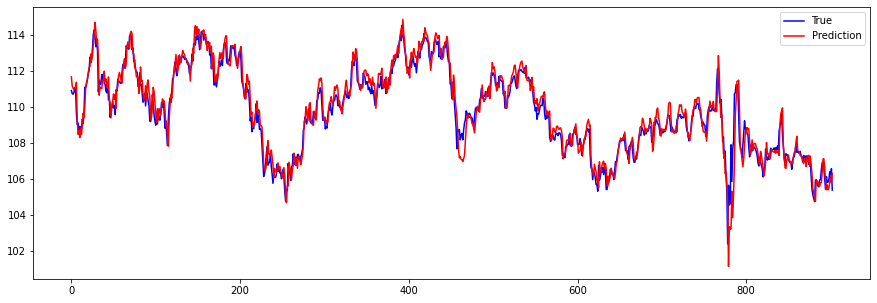

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.plot(label_emb_list_val,'blue',label='True')
plt.plot(test_after_train,'red',label='Prediction')
plt.legend()
plt.show()

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
id = '1ocyyFOSK9ksPMUECThkFOvRCU3gxjeHu'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('bilstm_model.pt')

net = torch.load('bilstm_model.pt')
ot = net(val_input).detach().numpy()

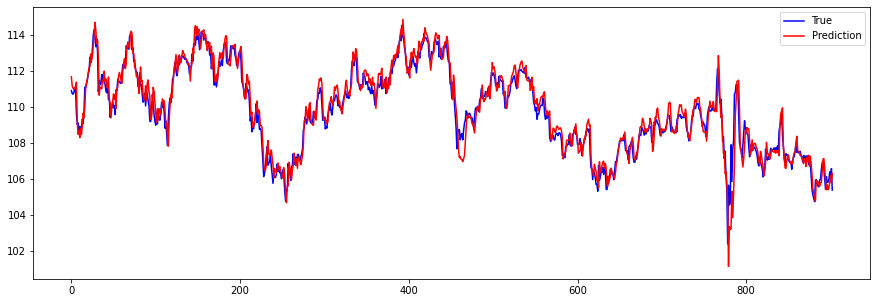

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.plot(label_emb_list_val,'blue',label='True')
plt.plot(ot,'red',label='Prediction')
plt.legend()
plt.show()

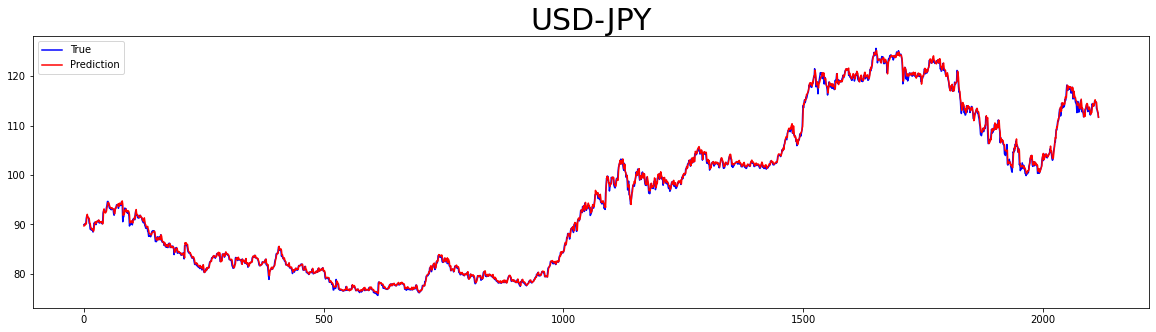

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(target_batch_torch,'blue',label='True')
plt.plot(train_after_train,'red',label='Prediction')

plt.title('USD-JPY',fontsize=  '30')
plt.legend(loc="upper left")

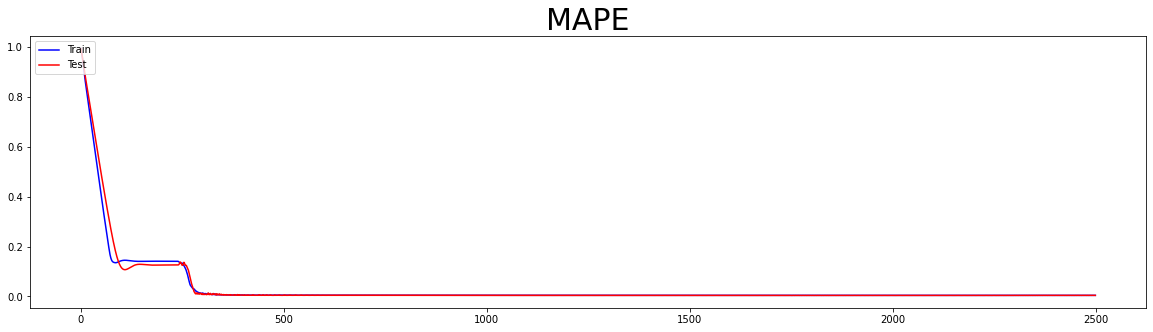

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(mape_list_train,'blue',label='Train')
plt.plot(mape_list_test,'red',label='Test')

plt.title('MAPE',fontsize=  '30')
plt.legend(loc="upper left")

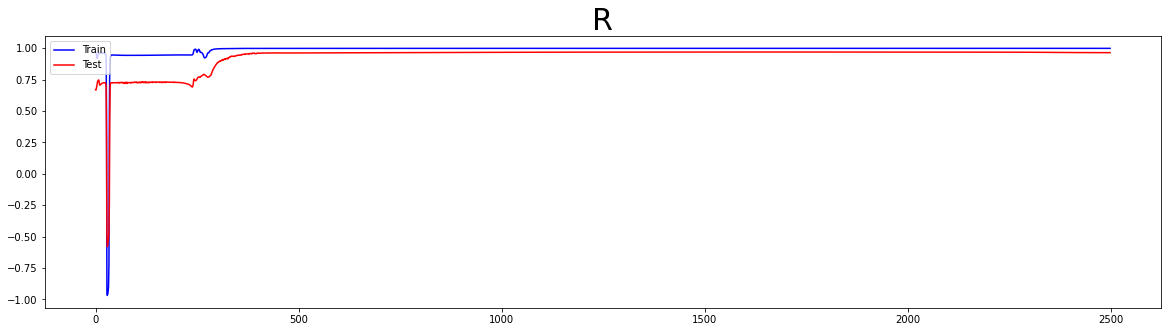

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(correlation_list_train,'blue',label='Train')
plt.plot(correlation_list_test,'red',label='Test')

plt.title('R',fontsize=  '30')
plt.legend(loc="upper left")

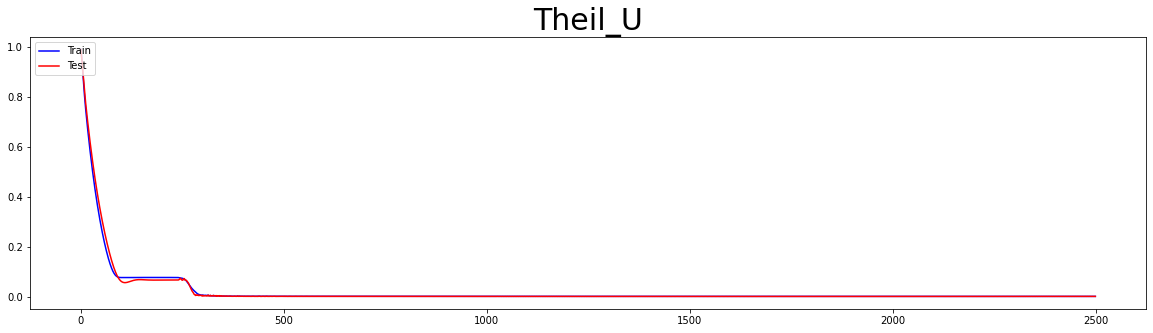

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(Theil_U_list_train,'blue',label='Train')
plt.plot(Theil_U_list_test,'red',label='Test')

plt.title('Theil_U',fontsize=  '30')
plt.legend(loc="upper left")

In [ ]:
print('Mape:%.5f, R:%.5f, Theil_U:%.5f'%(mape_list_test[-1],correlation_list_test[-1],Theil_U_list_test[-1]))

Mape:0.00411, R:0.96505, Theil_U:0.00288


In [ ]:
torch.save(net_bilstm,'bilstm_model.pt')



In [ ]:
name=['close']
test=pd.DataFrame(columns=name,data=test_after_train)
print(test)
test.to_csv('./backtesting_USD_JPY.csv',encoding='gbk')

          close
0    111.666817
1    111.162605
2    111.033134
3    110.975060
4    111.038277
..          ...
898  105.500153
899  105.801163
900  106.180229
901  105.766739
902  106.297966

[903 rows x 1 columns]


In [ ]:
print(mape_list_test.index(min(mape_list_test)))
print(Theil_U_list_test.index(min(Theil_U_list_test)))
print(correlation_list_test.index(max(correlation_list_test)))